## Baseline
This notebook implments a baseline model, which shows you how to handle the data and to provide a first very simple solution to the problem. You may re-use and modify any part of this notebook.

In [13]:
import os
import csv
import torch
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from ipywidgets import FloatProgress
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torchmetrics import AUROC, F1Score
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [3]:
data_dir = 'kaggle_data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used : {device}')

Device used : cuda


## Data Visualisation

In [45]:
train_df = pd.read_csv(os.path.join(data_dir, f'train_y.csv'))

In [63]:
train_df.columns

Index(['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions',
       'black', 'white', 'identity_any', 'severe_toxicity', 'obscene',
       'threat', 'insult', 'identity_attack', 'sexual_explicit', 'y',
       'from_source_domain'],
      dtype='object')

---------------------------
Number of comments: 269038
Number of toxic comments: 30515
---------------------------


<Axes: >

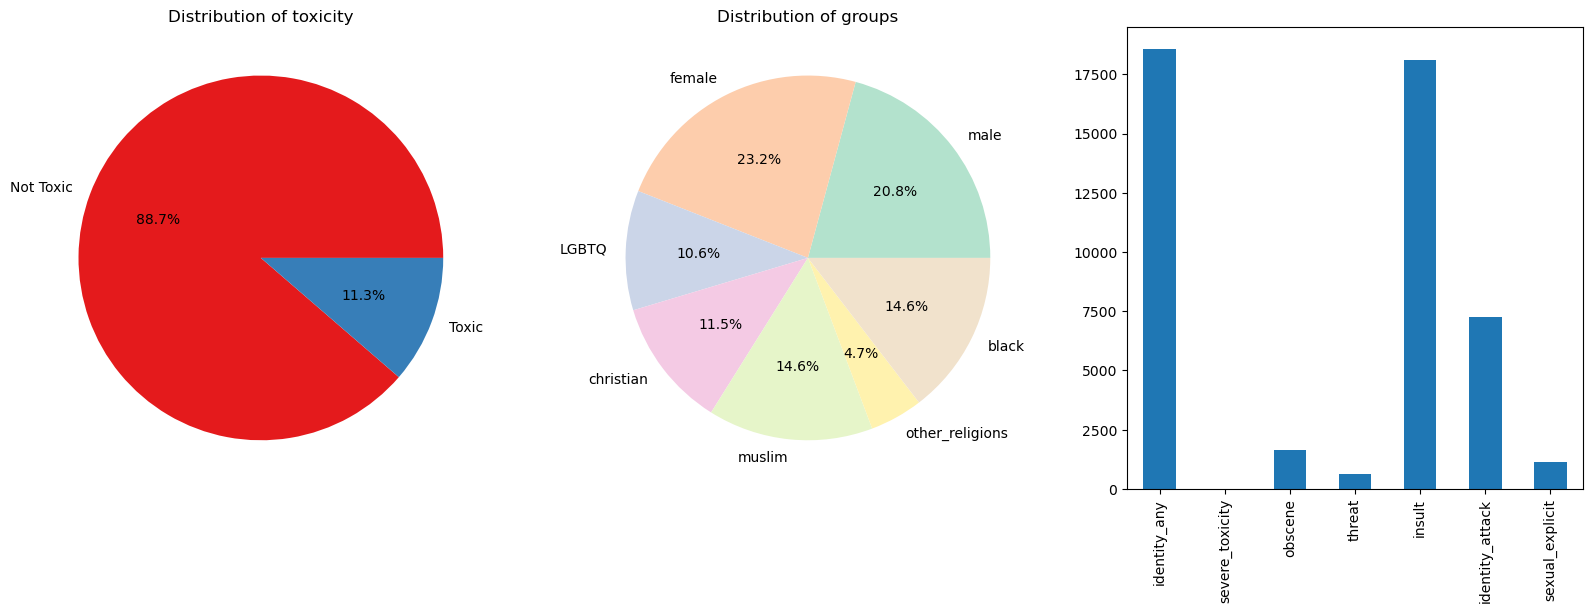

In [72]:
toxic_comment = train_df[train_df['y']==1]

print('---------------------------')
print(f'Number of comments: {len(train_df)}')
print(f'Number of toxic comments: {len(toxic_comment)}')
print('---------------------------')
_ , axes = plt.subplots(1,3, figsize = (20,6))

#TOXICITY CHART --------------------
toxicity_pie = axes[0].pie(train_df['y'].value_counts(), labels=["Not Toxic", "Toxic"], autopct='%1.1f%%', colors = plt.cm.Set1.colors)
axes[0].set_title("Distribution of toxicity")

#GROUP CHART --------------------
groups_pie = axes[1].pie(toxic_comment.sum().iloc[:7], labels=toxic_comment.columns[:7], autopct='%1.1f%%', colors = plt.cm.Pastel2.colors)
axes[1].set_title("Distribution of groups")

#TYPE CHART --------------------
toxic_comment.sum().iloc[8:-2].plot(kind='bar')

We first start by defining the dataset class which takes as input the path to the data and the mode (`train`, `val`, or `train`). This fits a count vectorizer using the training set, and uses it on the validation and test sets.

In [3]:
def clean(comment):
    comment = comment.lower()
    comment = re.sub("\\n", " ", comment)
    comment = re.sub("\\r", " ", comment)
    return comment

In [4]:
class BertVectorizer:
    def __init__(self, tokenizer, bert_model):
        self.tokenizer = tokenizer
        self.bert_model = bert_model

    def transform(self, texts):
        # Tokenize and pad the text
        tokens = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        with torch.no_grad():
            outputs = self.bert_model(**tokens)
        # Use the [CLS] token's output as the sentence embedding
        embeddings = outputs.last_hidden_state[:, 0, :]
        return embeddings

In [12]:
class BaselineDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None):
        super(BaselineDataset, self).__init__()
        assert mode in ['train', 'val', 'test']
        self.mode = mode

        # Load data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)
        self.data.fillna("", inplace=True)
        self.data["string"] = self.data["string"].apply(lambda x: clean(x))

        # Load labels
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # Vectorizer
        if self.mode == 'train':
            self.vectorizer = vectorizer
            self.data_transformed = self.vectorizer.transform(torch.tensor(self.data["string"].to_list()))
        else:
            self.vectorizer = vectorizer
            self.data_transformed = self.vectorizer.transform(torch.tensor(self.data["string"].to_list()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data_transformed[idx].toarray()).float()
        if self.mode == 'test':
            return x, idx
        else:
            y = torch.tensor([self.label.loc[idx, 'y']])
            return x, y, idx

In [ ]:
class PrecomputedDataset(Dataset):
    def __init__(self, embedding_path, label_path=None):
        self.embeddings = torch.load(embedding_path)  # Load precomputed embeddings
        self.labels = torch.load(label_path) if label_path else None

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        if self.labels is not None:
            y = self.labels[idx]
            return x, y, idx
        else:
            return x, idx

In [14]:
BERT_MODEL = 'bert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
bert_model = BertModel.from_pretrained(BERT_MODEL).to(device)

def clean(comment):
    # Clean text (customize as needed)
    comment = comment.lower().strip()
    return comment

def precompute_embeddings(data_dir, mode, output_dir):
    # Load data
    data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)
    data.fillna("", inplace=True)
    data["string"] = data["string"].apply(lambda x: clean(x))

    embeddings = []
    labels = None

    if mode != 'test':
        labels = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

    # Compute embeddings
    bert_model.eval()
    for text in tqdm(data["string"].tolist(), desc=f"Processing {mode}"):
        # Tokenize
        tokens = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        input_ids = tokens["input_ids"].to(device)
        attention_mask = tokens["attention_mask"].to(device)

        # Get BERT embeddings
        with torch.no_grad():
            output = bert_model(input_ids, attention_mask=attention_mask)
        cls_embedding = output.last_hidden_state[:, 0, :]  # Extract [CLS] token

        embeddings.append(cls_embedding.squeeze(0).cpu())

    # Save embeddings and labels
    embeddings_tensor = torch.stack(embeddings)
    torch.save(embeddings_tensor, os.path.join(output_dir, f"{mode}_embeddings.pt"))

    if labels is not None:
        labels_tensor = torch.tensor(labels['y'].values)
        torch.save(labels_tensor, os.path.join(output_dir, f"{mode}_labels.pt"))

# Define paths
data_dir = "kaggle_data"
output_dir = "embeddings"
os.makedirs(output_dir, exist_ok=True)

# Precompute for train, val, and test
precompute_embeddings(data_dir, 'train', output_dir)
precompute_embeddings(data_dir, 'val', output_dir)
precompute_embeddings(data_dir, 'test', output_dir)

Processing train:   3%|▎         | 6838/269038 [02:21<1:30:14, 48.42it/s]


KeyboardInterrupt: 

In [13]:
BERT_MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
# vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
bert_model = BertModel.from_pretrained(BERT_MODEL).to(device)
vectorizer = BertVectorizer(tokenizer, bert_model)

train_dataset = BaselineDataset(data_dir, 'train', vectorizer=vectorizer)
val_dataset = BaselineDataset(data_dir, 'val', train_dataset.vectorizer)

ValueError: too many dimensions 'str'

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

We will define two models, one which will be a simple MLP, and another one which will generate random predictions to use as comparison.

In [8]:
class BaselineClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(BaselineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [9]:
class ImprovedClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(ImprovedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.5)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        # Xavier initialization for linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.ln1(F.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.ln2(F.relu(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))  # Raw logits for BCEWithLogitsLoss
        return x

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, dropout_prob=0.3):
        super(RNNClassifier, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            bidirectional=True
        )
        
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)  # Normalize LSTM output
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout_prob)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x, lengths=None):
        if lengths is not None:
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        lstm_out, _ = self.lstm(x)
        
        if lengths is not None:
            lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        lstm_out = self.layer_norm(lstm_out[:, -1, :])  # Last hidden state
        
        # Fully connected layers
        x = F.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Binary classification output
        
        return x

Let's check the performance of the random classifier on the validation set.

In [10]:
def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga

In [11]:
def evaluate_model(model, dataloader, criterion):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        with torch.no_grad():
            pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label)
    return dataset_loss, dataset_metric

Now let's train the MLP baseline classifier.

In [12]:
def train_model(model, optimizer, criterion, dataloader):
    """
        Train a model for one epoch.
        arguments:
            model [torch.nn.Module]: model to evaluate
            oprimizer [torch.optim]: optimizer used for training
            criterion [torch.nn.modules.loss]: desired loss to compute
            dataloader [torch.utils.data.DataLoader]: dataloader used for training
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.train()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        loss.backward()
        optimizer.step()

        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, y = dataloader.dataset.label)
    return dataset_loss, dataset_metric

In [13]:
# input_size = len(train_dataset.vectorizer.get_feature_names_out())
LR = 1e-2
epochs=3
val_epoch=1
# model = ImprovedClassifier(input_size, 128).to(device)
model = RNNClassifier(input_size=768, hidden_dim=128, num_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

In [14]:
import torchmetrics
from torch.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_

# Initialize scaler for mixed precision
scaler = GradScaler('cuda')

# Initialize early stopping parameters
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Training Loop
for epoch in range(epochs):
    model.train()
    train_losses, train_predictions, train_indices = [], [], []
    
    for x, y, idx in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        with autocast('cuda'):  # Mixed precision
            pred = model(x.to(device))
            loss = criterion(pred.squeeze(), y.to(device).squeeze().float())
        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        scaler.step(optimizer)
        scaler.update()

        train_losses.extend([loss.item()] * len(y))
        train_predictions.extend(pred.detach().squeeze().tolist())
        train_indices.extend(idx.tolist())

    train_pred_df = pd.DataFrame({'index': train_indices, 'pred': train_predictions})
    train_loss = np.mean(train_losses)
    train_wga = worst_group_accuracy(train_pred_df, y=train_dataloader.dataset.label)
    train_accuracy = accuracy_score(y_true=np.array(train_dataloader.dataset.label['y']), y_pred=np.array(train_predictions)>0.5)
    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, WGA: {train_wga:.4f}, Accuracy: {train_accuracy}')

    # Validation Phase
    if epoch % val_epoch == 0:
        model.eval()
        val_losses, val_predictions, val_indices = [], [], []
        for x, y, idx in tqdm(val_dataloader, leave=False):
            with torch.no_grad():
                with autocast('cuda'):  # Mixed precision
                    pred = model(x.to(device))
                    loss = criterion(pred.squeeze(), y.to(device).squeeze().float())
                val_losses.extend([loss.item()] * len(y))
                val_predictions.extend(pred.detach().squeeze().tolist())
                val_indices.extend(idx.tolist())

        val_pred_df = pd.DataFrame({'index': val_indices, 'pred': val_predictions})
        val_loss = np.mean(val_losses)
        val_wga = worst_group_accuracy(val_pred_df, val_dataloader.dataset.label)
        val_accuracy = accuracy_score(y_true=np.array(val_dataloader.dataset.label['y']), y_pred=np.array(val_predictions)>0.5) 
        print(f'Validation Loss: {val_loss:.4f}, WGA: {val_wga:.4f}, Accuracy: {val_accuracy}')

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'model/best_model.pth')
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/3 - Train Loss: 0.6936, WGA: 0.6868, Accuracy: 0.8869750741530936


Validation Loss: 0.6931, WGA: 0.6774, Accuracy: 0.8881142098273572


Epoch 2/3 - Train Loss: 0.6931, WGA: 0.6856, Accuracy: 0.8865773608189178


Validation Loss: 0.6931, WGA: 0.6774, Accuracy: 0.8881142098273572


Epoch 3/3 - Train Loss: 0.6931, WGA: 0.6856, Accuracy: 0.8865773608189178


Validation Loss: 0.6931, WGA: 0.6774, Accuracy: 0.8881142098273572


Once we are happy with our results, we want to make a prediction on the test set. Your submission `.csv` file should contain 2 columns:
- ID: with the id of each prediction (do not shuffle to not mix things up)
- pred: the prediction of the model (thresholded or not)

In [21]:
#model = RandomClassifier()
test_dataset = BaselineDataset(data_dir, 'test', train_dataset.vectorizer)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
model.eval()
test_predictions, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
    with torch.no_grad():
        pred = (model(x).squeeze() > 0.5).int()
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())

In [22]:
pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction.csv', index=False)